# MLA-ViT Comparative Evaluation on CIFAR-100

This notebook evaluates and compares three Vision Transformer variants on the CIFAR-100 dataset:

- **ViT-MHA**: A standard Vision Transformer using Multi-Head Attention.
- **ViT-MLA**: A Vision Transformer using Multi-Head Latent Attention for reduced attention overhead.
- **ViT-MLA+RoPE**: The MLA variant enhanced with Rotary Positional Embedding for improved positional encoding.

All models are trained for 500 epochs with identical configurations to ensure fairness. Metrics such as accuracy and training time are recorded for comparison.


In [ ]:
# Import required libraries.
!pip install torch torchvision matplotlib
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
from typing import List, Tuple

from models.vit_mha import ViT_MHA
from models.vit_mla import MLA_ViT



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Tyo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
# Set experiment-wide hyperparameters
BATCH_SIZE = 128
EPOCHS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [ ]:
# Load CIFAR-10 dataset

train_data_set = torchvision.datasets.CIFAR10(root='dataset', train=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(size=(32, 32), padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
]), download=True)


test_data_set = torchvision.datasets.CIFAR10(root='dataset', train=False, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
]), download=True)


train_data_load = DataLoader(train_data_set, batch_size=1000, shuffle=True, drop_last=True)

test_data_load = DataLoader(test_data_set, batch_size=1000, shuffle=False, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def train_and_evaluate(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    device: torch.device,
    num_epochs: int = 100,
    learning_rate: float = 0.001
) -> Tuple[List[float], List[float]]:
    """
    Train and evaluate a model, returning training and validation accuracies.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        start = time.time()
        
        # Training phase
        model.train()
        correct_train, total_train, train_loss = 0, 0, 0
        
        for imgs, targets in train_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()
            train_loss += loss.item()
        
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        correct_test, total_test, test_loss = 0, 0, 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                _, predicted = torch.max(outputs.data, 1)
                total_test += targets.size(0)
                correct_test += (predicted == targets).sum().item()
                test_loss += loss.item()
        
        valid_accuracy = 100 * correct_test / total_test
        test_accuracies.append(valid_accuracy)

        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Acc: {train_accuracy:.2f}%, '
              f'Val Acc: {valid_accuracy:.2f}%, '
              f'Time: {time.time()-start:.2f}s')
    
    return train_accuracies, test_accuracies

def plot_results(
    results: dict,
    num_epochs: int,
    title: str = "Model Comparison"
):
    """
    Plot training and validation accuracies for multiple models.
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, num_epochs+1)
    
    for model_name, (train_acc, val_acc) in results.items():
        plt.plot(epochs, train_acc, '--', label=f'{model_name} (Train)')
        plt.plot(epochs, val_acc, '-', label=f'{model_name} (Val)')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


Training MLA-ViT
Epoch 1/300: Train Acc: 21.50%, Val Acc: 31.25%, Time: 12.74s
Epoch 2/300: Train Acc: 31.88%, Val Acc: 35.56%, Time: 12.01s
Epoch 3/300: Train Acc: 35.30%, Val Acc: 38.30%, Time: 12.09s
Epoch 4/300: Train Acc: 37.18%, Val Acc: 39.58%, Time: 12.16s
Epoch 5/300: Train Acc: 38.97%, Val Acc: 41.93%, Time: 12.14s
Epoch 6/300: Train Acc: 40.37%, Val Acc: 42.56%, Time: 12.23s
Epoch 7/300: Train Acc: 41.65%, Val Acc: 44.42%, Time: 12.06s
Epoch 8/300: Train Acc: 42.74%, Val Acc: 45.24%, Time: 12.02s
Epoch 9/300: Train Acc: 44.26%, Val Acc: 46.52%, Time: 12.14s
Epoch 10/300: Train Acc: 45.60%, Val Acc: 47.39%, Time: 12.12s
Epoch 11/300: Train Acc: 46.37%, Val Acc: 50.54%, Time: 12.08s
Epoch 12/300: Train Acc: 47.49%, Val Acc: 50.72%, Time: 12.01s
Epoch 13/300: Train Acc: 48.02%, Val Acc: 50.82%, Time: 12.02s
Epoch 14/300: Train Acc: 48.74%, Val Acc: 51.80%, Time: 11.98s
Epoch 15/300: Train Acc: 49.76%, Val Acc: 51.65%, Time: 12.17s
Epoch 16/300: Train Acc: 50.41%, Val Acc: 52.7

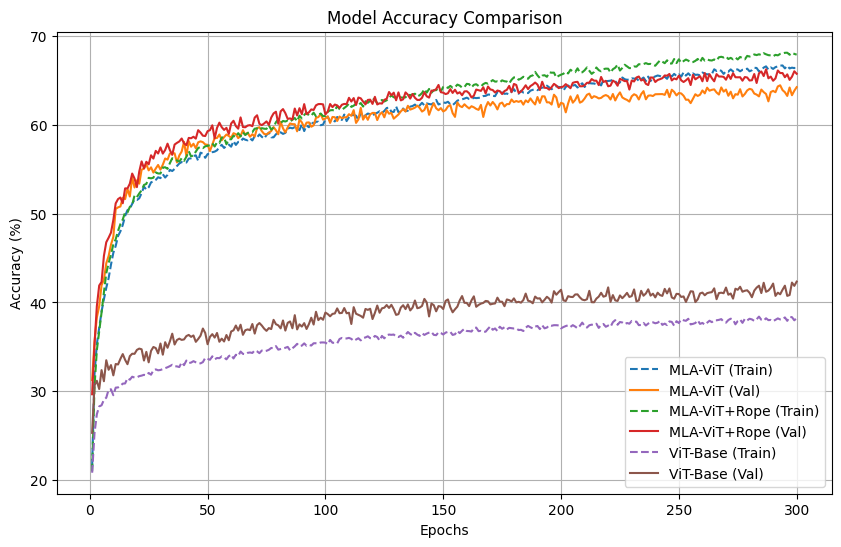

In [12]:

# Both use Deepseek's MLAConfig
config_rope = MLAConfig(
    hidden_size=768,
    num_heads=1,
    max_position_embeddings=1024,
    rope_theta=1280,
    attention_dropout=0, 
    q_lora_rank=1536,
    qk_rope_head_dim=64,
    kv_lora_rank=512,
    v_head_dim=128,
    qk_nope_head_dim=128,
    attention_bias=False,
)

config_no_rope = MLAConfig(
    hidden_size=768,  # Keep consistent with PatchEmbedding
    num_heads=1,
    max_position_embeddings=1024,
    rope_theta=1280,
    attention_dropout=0,
    q_lora_rank=1536,
    qk_rope_head_dim=0, # No ROPE
    kv_lora_rank=512,
    v_head_dim=128,
    qk_nope_head_dim=128,
    attention_bias=False,
)
models = {
        "MLA-ViT": MLA_ViT(config_no_rope, in_channels=3).to(DEVICE),
        "MLA-ViT+Rope": MLA_ViT(config_rope, in_channels=3).to(DEVICE),
        "ViT-Base":  ViT_MHA(image_size=32, patch_size=8, num_classes=10, embed_dim=256, num_heads=1, num_layers=1).to(DEVICE),
    }

results = {}
num_epochs = 300

# Train and evaluate each model
for name, model in models.items():
    print(f"\n{'='*40}")
    print(f"Training {name}")
    print(f"{'='*40}")
    
    train_acc, val_acc = train_and_evaluate(
        model=model,
        train_loader=train_data_load,
        test_loader=test_data_load,
        device=DEVICE,
        num_epochs=num_epochs
    )
    
    results[name] = (train_acc, val_acc)
    
    # Print model parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Plot comparison
plot_results(results, num_epochs, "Model Accuracy Comparison")